In [1]:
import pandas as pd
from io import StringIO

def parse_html_file(file_path):
    """
    Read an HTML file and parse its table content into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the HTML file
    
    Returns:
    pandas.DataFrame: Parsed table data
    """
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Read HTML content using pandas
    df = pd.read_html(StringIO(html_content))[0]
    
    # Clean up column names
    df.columns = df.columns.str.strip()
    
    # Replace empty strings with NaN
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    
    # Convert wage column to numeric, removing '£' and 'p/w'
    if 'Wage' in df.columns:
        df['Wage'] = df['Wage'].str.replace('£', '').str.replace(' p/w', '').str.replace(',', '')
        df['Wage'] = pd.to_numeric(df['Wage'], errors='coerce')
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Age', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 'Ant', 
                      'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 'Fin',
                      'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 'OtB',
                      'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Thr',
                      'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

df = parse_html_file("wage_player_export.html")
df = df.drop(columns=["Inf"])

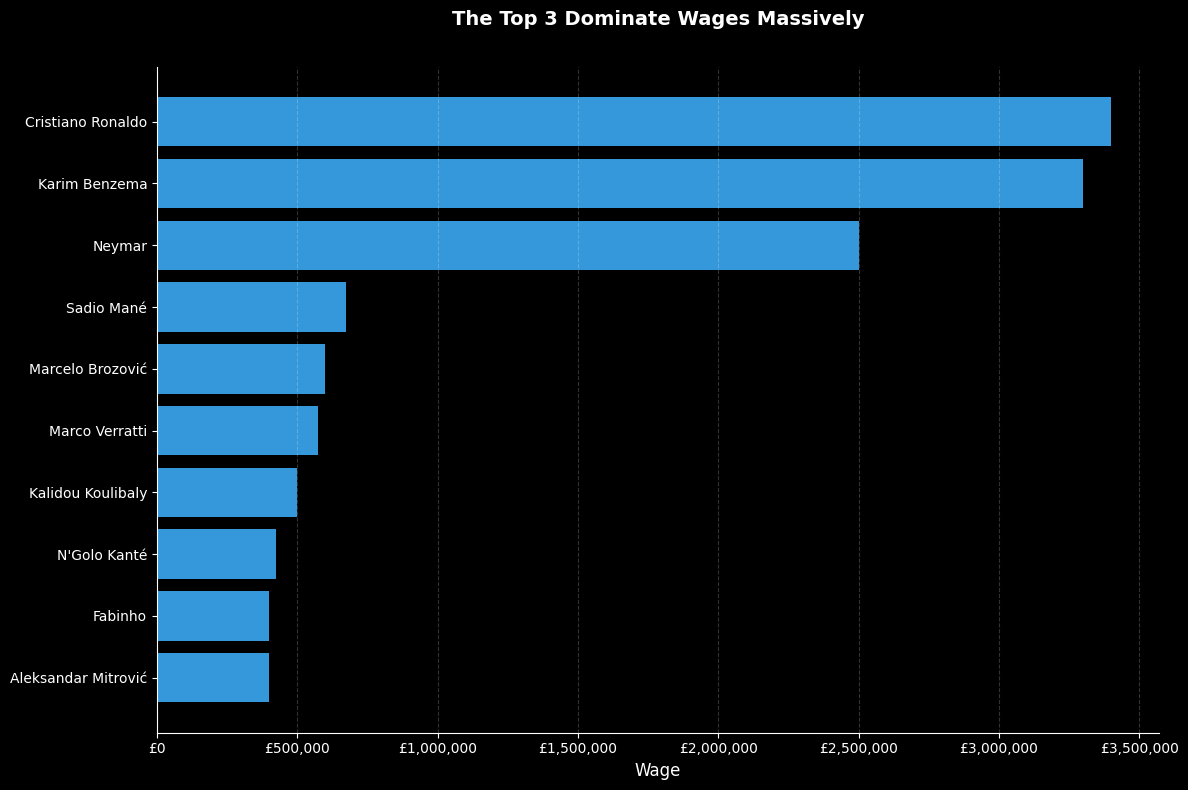

In [2]:
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
# Sort in descending order (highest first)
df = df.sort_values(by="Wage", ascending=False)
top_10 = df.head(10)[::-1]  # Reverse the order after getting top 10

# Create dark-themed horizontal bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
plt.barh(top_10['Name'], top_10['Wage'], color='#3498db')

# Customize the plot
plt.title('The Top 3 Dominate Wages Massively', fontsize=14, pad=30, fontdict={"fontweight":"bold"})
plt.xlabel('Wage', fontsize=12)

# Format wage values on x-axis with comma separators
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{format(int(x), ",")}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add grid lines
plt.grid(True, axis='x', linestyle='--', alpha=0.2)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()

In [3]:
def process_football_data(df):
    """
    Process football player data with position, contract, and physical features.
    Handles missing values and invalid dates in the contract expiry field.
    """
    # Positional features
    position_features = {
        "is_gk": r"GK",
        "is_cb": r"D \((C|LC|RC|RLC)\)",
        "is_fb": r"D \([LR]+[C]?\)|WB",
        "is_dm": r"DM",
        "is_cm": r"M \([LR]*C[LR]*\)",
        "is_w": r"(M|AM|M/AM) \([LR]+\)",
        "is_am": r"AM \([LR]*C[LR]*\)",
        "is_st": r"ST"
    }
    
    for feature, pattern in position_features.items():
        df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
    
    # Calculate number of positions
    position_cols = ["is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st"]
    df["num_pos"] = df[position_cols].sum(axis=1)
    
    # Foot features
    strong_feet = ["Strong", "Fairly Strong", "Very Strong"]
    df["strong_left"] = df["Left Foot"].isin(strong_feet).astype(int)
    df["strong_right"] = df["Right Foot"].isin(strong_feet).astype(int)
    
    # Contract feature with proper handling of invalid dates
    reference_date = pd.to_datetime("2023-07-01")
    
    def process_expiry_date(date_str):
        if pd.isna(date_str) or date_str == "-":
            return pd.NaT
        try:
            return pd.to_datetime(date_str)
        except:
            return pd.NaT
    
    df["Expires"] = df["Expires"].apply(process_expiry_date)
    df["days_until_expiry"] = (df["Expires"] - reference_date).dt.days
    
    # Height feature
    def height_to_cm(height):
        try:
            feet, inches = map(int, height.replace('"', '').split("'"))
            return (feet * 30.48) + (inches * 2.54)
        except:
            return np.nan
    
    df["height_cm"] = df["Height"].apply(height_to_cm)
    
    # Remove goalkeepers
    df = df[~df["Position"].str.contains("GK", na=False)]
    
    return df

df = process_football_data(df)


C:\Users\Owner\AppData\Local\Temp\ipykernel_39328\2724279043.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_39328\2724279043.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[feature] = df["Position"].str.contains(pattern, regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_39328\2724279043.py:37: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [4]:
reg_cols = [["Wage", "is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st", "num_pos", "Age",
              "strong_left", "strong_right", "days_until_expiry", "height_cm", "Club", "Division", "Nat", 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer',
       'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec',
       'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr',
       'Lon', 'Mar', 'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck',
       'Tea', 'Tec', 'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']]

reg_df = pd.DataFrame()



reg_df = df[~df['Position'].str.contains('GK', na=False)][reg_cols[0]].copy() # remove goalkeepers

reg_df = pd.get_dummies(reg_df, columns=['Nat', 'Club', 'Division'])

reg_df


Wage  is_cb  is_fb  is_dm  is_cm  is_w  is_am  is_st  num_pos  Age  \
0      3400000      0      0      0      0     0      0      1        1   39   
1      3300000      0      0      0      0     0      0      1        1   36   
2      2500000      0      0      0      1     0      1      1        3   32   
3       675000      0      0      0      1     0      1      1        3   32   
4       600000      0      0      1      1     0      0      0        2   31   
...        ...    ...    ...    ...    ...   ...    ...    ...      ...  ...   
15766     1000      0      0      1      1     0      0      0        2   29   
15767     1000      1      1      0      0     1      0      0        3   25   
15768     1000      0      0      0      0     1      0      1        2   25   
15769     1000      0      0      1      1     0      0      0        2   31   
16249     1000      0      0      0      0     1      0      0        1   28   

       strong_left  strong_right  days_until_expiry  height_cm  Com  Ecc  Pun  \
0                1             1              365.0     187.96    2    1    2   
1                1             1              365.0     185.42    1    1    2   
2                1             1              365.0     175.26    2    4    1   
3                0             1             1095.0     175.26    1    1    1   
4                0             1              730.0     180.34    3    2    2   
...            ...           ...                ...        ...  ...  ...  ...   
15766            0             1              183.0     185.42    3    1    2   
15767            1             0             1095.0     180.34    2    1    3   
15768            0             1              365.0     175.26    2    2    2   
15769            0             1              730.0     175.26    2    1    1   
16249            1             1              365.0     172.72    3    2    1   

       1v1  Acc  Aer  Agg  Agi  Ant  Bal  Bra  Cmd  Cnt  Cmp  Cro  Dec  Det  \
0        3   11    2    6   10   17   13   13    2   10   15   11   12   20   
1        3   12    3    7   13   15   15   10    3   11   17   12   15   16   
2        1   15    2   10   15   15   14   14    1   10   17   16   14   16   
3        2   15    2   13   15   15   13   14    2   10   13   11   12   17   
4        1   11    3   14   12   15   16   13    3   16   15   11   14   16   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
15766    2   14    1   12   13   10   11   12    2   11    8    8    9   10   
15767    2   12    2   15   12    8   13   10    2    9   10   12    8   20   
15768    1   15    2   13   10   11   10   10    3   10   11    9   10   10   
15769    2   10    1   10   11   11   12   12    1   11   11   10   11   13   
16249    1   13    3   12   12   11    8   12    2    9   12    8    9   12   

       Dri  Fin  Fir  Fla  Han  Hea  Jum  Kic  Ldr  Lon  Mar  OtB  Pac  Pas  \
0       13   17   15   17    1   18   16    1   19   15    3   18   13   13   
1       16   17   20   17    2   14   11    1   12   12    6   15   12   17   
2       20   16   18   20    3    8    6    3   14   15    4   16   15   17   
3       16   14   14   15    2   12   10    2   11   12    8   16   15   12   
4       10   11   16   12    1   11   10    3   14   12   12   13   12   17   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
15766   11    5   10   10    2    7   12    1    6    5   10   11   11   10   
15767   12    8   12   12    4    6   10    1    4    5    7   10   11   11   
15768    9   11    7    8    2    7    7    1    6    7    5   12   14    9   
15769   11    8   11    8    2    8    8    3   12    9   12   10   12   12   
16249   10    6   11    8    1    7    7    3    8    7    7    8   14   11   

       Pos  Ref  Sta  Str  Tck  Tea  Tec  Thr  TRO  Vis  Wor  Cor  Fre  L Th  \
0        4    3   13   15    5    7   16    2    1   13    7   10   13     5   
1       10    3   

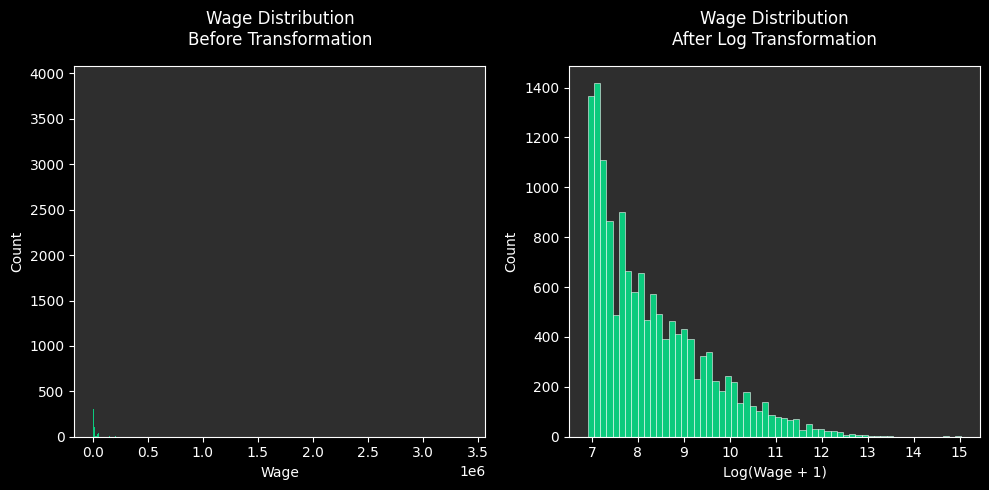

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style to dark theme
plt.style.use('dark_background')
# Set the figure size
plt.figure(figsize=(10, 5))

# Customize colors and appearance
custom_style = {
    'axes.facecolor': '#2e2e2e',
    'figure.facecolor': '#1e1e1e',
    'grid.color': '#404040',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
}

# Apply custom style
plt.rcParams.update(custom_style)

# Create subplot for before transformation
plt.subplot(1, 2, 1)
sns.histplot(df['Wage'], color='#00ff99')
plt.title('Wage Distribution\nBefore Transformation', color='white', pad=15)
plt.xlabel('Wage')
plt.ylabel('Count')

# Create subplot for after transformation
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['Wage']), color='#00ff99')
plt.title('Wage Distribution\nAfter Log Transformation', color='white', pad=15)
plt.xlabel('Log(Wage + 1)')
plt.ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [6]:
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
# import xgboost as xgb
# import numpy as np
# import pandas as pd

# # Prepare data
# X = reg_df.drop('Wage', axis=1)  # Features
# y = np.log1p(reg_df['Wage'])     # Log-transformed target

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42
# )

# # Define parameter grid
# param_grid = {
#     'n_estimators': [500, 1000],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [3, 5],
#     'subsample': [0.7, 0.8],
#     'colsample_bytree': [0.7, 0.8],
#     'min_child_weight': [3, 5],
#     'reg_alpha': [0.1, 0.5],    # L1 regularization
#     'reg_lambda': [1.0]         # L2 regularization
# }

# # Initialize base model
# base_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     n_jobs=-1  # Use all available cores
# )

# # Fit GridSearchCV
# print("Starting GridSearchCV...")
# grid_search.fit(X_train, y_train)

# # Print best parameters and score
# print("\nBest parameters found:")
# print(grid_search.best_params_)
# print(f"\nBest RMSE: {np.sqrt(-grid_search.best_score_):.3f}")

# # Use best model for predictions
# best_model = grid_search.best_estimator_

# # Get predictions for both train and test sets
# y_train_pred = best_model.predict(X_train)
# y_test_pred = best_model.predict(X_test)

# # Transform predictions back to original scale
# y_train_original = np.expm1(y_train)
# y_train_pred_original = np.expm1(y_train_pred)
# y_test_original = np.expm1(y_test)
# y_test_pred_original = np.expm1(y_test_pred)

# print("\nModel Performance and Overfitting Analysis:")
# print("-" * 50)

# # Log scale metrics
# print("Log Scale Metrics:")
# train_r2_log = r2_score(y_train, y_train_pred)
# test_r2_log = r2_score(y_test, y_test_pred)
# train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
# test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

# print(f"Training R²: {train_r2_log:.3f}")
# print(f"Test R²: {test_r2_log:.3f}")
# print(f"R² Difference: {train_r2_log - test_r2_log:.3f}")
# print(f"\nTraining RMSE: {train_rmse_log:.3f}")
# print(f"Test RMSE: {test_rmse_log:.3f}")
# print(f"RMSE Difference: {test_rmse_log - train_rmse_log:.3f}")

# # Original scale metrics
# print("\nOriginal Scale Metrics:")
# train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred_original)
# test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original)
# train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
# test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

# print(f"Training MAPE: {train_mape:.1%}")
# print(f"Test MAPE: {test_mape:.1%}")
# print(f"MAPE Difference: {test_mape - train_mape:.1%}")
# print(f"\nTraining MAE: £{train_mae:,.2f}")
# print(f"Test MAE: £{test_mae:,.2f}")
# print(f"MAE Difference: £{test_mae - train_mae:,.2f}")

# # Error distributions
# train_errors = abs(y_train_original - y_train_pred_original)
# test_errors = abs(y_test_original - y_test_pred_original)

# print('\nError Distribution (Original Scale):')
# print("Training Errors:")
# print(f'25th percentile: £{np.percentile(train_errors, 25):,.2f}')
# print(f'Median error: £{np.percentile(train_errors, 50):,.2f}')
# print(f'75th percentile: £{np.percentile(train_errors, 75):,.2f}')
# print("\nTest Errors:")
# print(f'25th percentile: £{np.percentile(test_errors, 25):,.2f}')
# print(f'Median error: £{np.percentile(test_errors, 50):,.2f}')
# print(f'75th percentile: £{np.percentile(test_errors, 75):,.2f}')

# # Percentage error distributions
# train_percent_errors = abs((y_train_original - y_train_pred_original) / y_train_original * 100)
# test_percent_errors = abs((y_test_original - y_test_pred_original) / y_test_original * 100)

# print('\nPercentage Error Distribution:')
# print("Training Errors:")
# print(f'25th percentile: {np.percentile(train_percent_errors, 25):.1f}%')
# print(f'Median error: {np.percentile(train_percent_errors, 50):.1f}%')
# print(f'75th percentile: {np.percentile(train_percent_errors, 75):.1f}%')
# print("\nTest Errors:")
# print(f'25th percentile: {np.percentile(test_percent_errors, 25):.1f}%')
# print(f'Median error: {np.percentile(test_percent_errors, 50):.1f}%')
# print(f'75th percentile: {np.percentile(test_percent_errors, 75):.1f}%')

# # Feature importance
# importance_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': best_model.feature_importances_
# })
# print("\nTop 10 Most Important Features:")
# print(importance_df.sort_values('importance', ascending=False).head(10))

# # Error by wage brackets
# train_brackets = pd.qcut(y_train_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
# test_brackets = pd.qcut(y_test_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# train_error_by_bracket = pd.DataFrame({
#     'Actual': y_train_original,
#     'Predicted': y_train_pred_original,
#     'Bracket': train_brackets
# })
# test_error_by_bracket = pd.DataFrame({
#     'Actual': y_test_original,
#     'Predicted': y_test_pred_original,
#     'Bracket': test_brackets
# })

# train_error_by_bracket['Percentage_Error'] = abs(train_error_by_bracket['Predicted'] - train_error_by_bracket['Actual']) / train_error_by_bracket['Actual'] * 100
# test_error_by_bracket['Percentage_Error'] = abs(test_error_by_bracket['Predicted'] - test_error_by_bracket['Actual']) / test_error_by_bracket['Actual'] * 100

# print("\nMAPE by Wage Bracket:")
# print("Training:")
# print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
# print("\nTest:")
# print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))

# # Save CV results to DataFrame
# cv_results = pd.DataFrame(grid_search.cv_results_)
# cv_results = cv_results.sort_values('rank_test_score')

# # Print top 5 parameter combinations
# print("\nTop 5 Parameter Combinations:")
# columns_to_show = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
# print(cv_results[columns_to_show].head())

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb
import numpy as np
import pandas as pd

# Prepare data
X = reg_df.drop('Wage', axis=1)  # Features
y = np.log1p(reg_df['Wage'])     # Log-transformed target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Initialize model with best parameters
# best_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     colsample_bytree=0.8,
#     learning_rate=0.05,
#     max_depth=4,
#     min_child_weight=5,
#     n_estimators=1000,
#     reg_alpha=0.3,
#     reg_lambda=1.0,
#     subsample=0.6,
#     random_state=42
# )

best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=6,
    n_estimators=800,
    reg_alpha=0.3,
    reg_lambda=1.5,
    subsample=0.6,
    random_state=42
)
# Fit model
print("Training model...")
best_model.fit(X_train, y_train)

# Get predictions for both train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Transform predictions back to original scale
y_train_original = np.expm1(y_train)
y_train_pred_original = np.expm1(y_train_pred)
y_test_original = np.expm1(y_test)
y_test_pred_original = np.expm1(y_test_pred)

print("\nModel Performance and Overfitting Analysis:")
print("-" * 50)

# Log scale metrics
print("Log Scale Metrics:")
train_r2_log = r2_score(y_train, y_train_pred)
test_r2_log = r2_score(y_test, y_test_pred)
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {train_r2_log:.3f}")
print(f"Test R²: {test_r2_log:.3f}")
print(f"R² Difference: {train_r2_log - test_r2_log:.3f}")
print(f"\nTraining RMSE: {train_rmse_log:.3f}")
print(f"Test RMSE: {test_rmse_log:.3f}")
print(f"RMSE Difference: {test_rmse_log - train_rmse_log:.3f}")

# Original scale metrics
print("\nOriginal Scale Metrics:")
train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred_original)
test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original)
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

print(f"Training MAPE: {train_mape:.1%}")
print(f"Test MAPE: {test_mape:.1%}")
print(f"MAPE Difference: {test_mape - train_mape:.1%}")
print(f"\nTraining MAE: £{train_mae:,.2f}")
print(f"Test MAE: £{test_mae:,.2f}")
print(f"MAE Difference: £{test_mae - train_mae:,.2f}")

# Error distributions
train_errors = abs(y_train_original - y_train_pred_original)
test_errors = abs(y_test_original - y_test_pred_original)

print('\nError Distribution (Original Scale):')
print("Training Errors:")
print(f'25th percentile: £{np.percentile(train_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(train_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(train_errors, 75):,.2f}')
print("\nTest Errors:")
print(f'25th percentile: £{np.percentile(test_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(test_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(test_errors, 75):,.2f}')

# Percentage error distributions
train_percent_errors = abs((y_train_original - y_train_pred_original) / y_train_original * 100)
test_percent_errors = abs((y_test_original - y_test_pred_original) / y_test_original * 100)

print('\nPercentage Error Distribution:')
print("Training Errors:")
print(f'25th percentile: {np.percentile(train_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(train_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(train_percent_errors, 75):.1f}%')
print("\nTest Errors:")
print(f'25th percentile: {np.percentile(test_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(test_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(test_percent_errors, 75):.1f}%')

# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(importance_df.sort_values('importance', ascending=False).head(10))

# Error by wage brackets
train_brackets = pd.qcut(y_train_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
test_brackets = pd.qcut(y_test_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

train_error_by_bracket = pd.DataFrame({
    'Actual': y_train_original,
    'Predicted': y_train_pred_original,
    'Bracket': train_brackets
})
test_error_by_bracket = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_test_pred_original,
    'Bracket': test_brackets
})

train_error_by_bracket['Percentage_Error'] = abs(train_error_by_bracket['Predicted'] - train_error_by_bracket['Actual']) / train_error_by_bracket['Actual'] * 100
test_error_by_bracket['Percentage_Error'] = abs(test_error_by_bracket['Predicted'] - test_error_by_bracket['Actual']) / test_error_by_bracket['Actual'] * 100

print("\nMAPE by Wage Bracket:")
print("Training:")
print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
print("\nTest:")
print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))

Training model...

Model Performance and Overfitting Analysis:
--------------------------------------------------
Log Scale Metrics:
Training R²: 0.821
Test R²: 0.794
R² Difference: 0.028

Training RMSE: 0.507
Test RMSE: 0.556
RMSE Difference: 0.049

Original Scale Metrics:
Training MAPE: 42.0%
Test MAPE: 46.9%
MAPE Difference: 4.9%

Training MAE: £4,748.70
Test MAE: £5,220.07
MAE Difference: £471.37

Error Distribution (Original Scale):
Training Errors:
25th percentile: £367.12
Median error: £931.41
75th percentile: £2,873.12

Test Errors:
25th percentile: £385.89
Median error: £1,072.07
75th percentile: £3,366.45

Percentage Error Distribution:
Training Errors:
25th percentile: 14.5%
Median error: 31.1%
75th percentile: 52.9%

Test Errors:
25th percentile: 15.1%
Median error: 33.3%
75th percentile: 57.2%

Top 10 Most Important Features:
                                 feature  importance
2157   Division_English Premier Division    0.050023
21                                   Ant   

C:\Users\Owner\AppData\Local\Temp\ipykernel_39328\616988876.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
C:\Users\Owner\AppData\Local\Temp\ipykernel_39328\616988876.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))


In [8]:
train_r2_original = r2_score(y_train_original, y_train_pred_original)
test_r2_original = r2_score(y_test_original, y_test_pred_original)

test_r2_original

0.6621719439756482

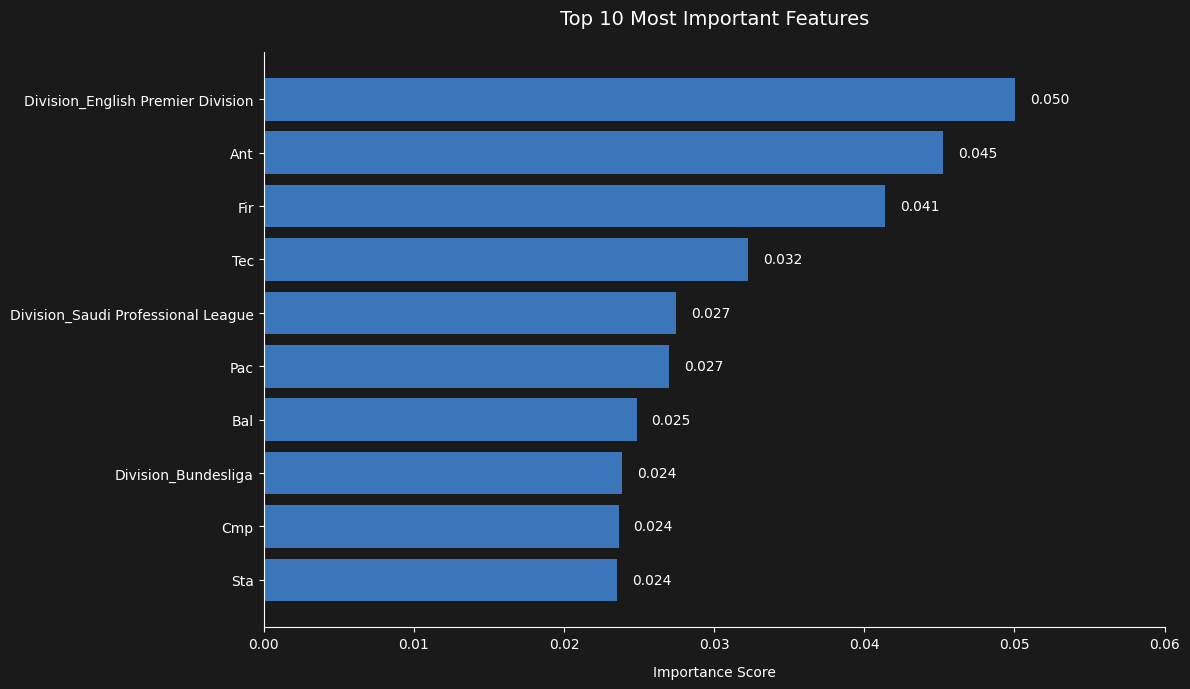

In [9]:
# Set style for dark theme
plt.style.use('dark_background')
plt.rcParams.update({
   'figure.facecolor': '#1a1a1a',
   'axes.facecolor': '#1a1a1a',
   'savefig.facecolor': '#1a1a1a'
})

# Sort and get top 10 features
top_10_features = importance_df.sort_values('importance', ascending=True).tail(10)

# Create figure with specific size
plt.figure(figsize=(12, 7))

# Create horizontal bar plot
bars = plt.barh(top_10_features['feature'], 
       top_10_features['importance'],
       color='#4a9eff',
       alpha=0.7)  # Light blue color with transparency

# Customize plot
plt.title('Top 10 Most Important Features', pad=20, fontsize=14, color='white')
plt.xlabel('Importance Score', labelpad=10, color='white')

# Style the ticks
plt.tick_params(axis='both', colors='white')

# Remove all spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove grid
plt.grid(False)

# Add value labels on bars
for i, bar in enumerate(bars):
   width = bar.get_width()
   plt.text(width + 0.001,  # Small offset from end of bar
            bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}',
            ha='left', 
            va='center',
            fontsize=10,
            color='white')

# Adjust layout and margins
plt.margins(x=0.2)  # Add some space on the right for labels
plt.tight_layout()

# Show plot
plt.show()

In [10]:

player = 'Bruno Fernandes'
player_data = df[df['Name'] == player ]

if len(player_data) == 0:
    print("Player not found in dataset")
else:
    # Create a single row dataframe with exactly the same features as X (training data)
    player_features = pd.DataFrame(columns=X.columns)
    player_features.loc[0] = 0  # Initialize with zeros
    
    # Fill in the numerical/boolean columns
    numeric_cols = ['is_cb', 'is_fb', 'is_dm', 'is_cm', 'is_w', 'is_am', 'is_st', 
                   'num_pos', 'Age', 'strong_left', 'strong_right', 'days_until_expiry', 
                   'height_cm', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 
                   'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 
                   'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 
                   'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 
                   'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_cols:
        if col in player_data.columns and col in player_features.columns:
            player_features[col] = player_data[col].values[0]
    
    # Handle categorical columns (one-hot encoded)
    # Nationality
    nat_col = f"Nat_{player_data['Nat'].values[0]}"
    if nat_col in player_features.columns:
        player_features[nat_col] = 1
    
    # Club
    club_col = f"Club_{player_data['Club'].values[0]}"
    if club_col in player_features.columns:
        player_features[club_col] = 1
    
    # Division
    div_col = f"Division_{player_data['Division'].values[0]}"
    if div_col in player_features.columns:
        player_features[div_col] = 1
    
    # Make prediction
    pred_log = best_model.predict(player_features)
    predicted_wage = np.expm1(pred_log[0])
    actual_wage = player_data['Wage'].values[0]
    
    print(f"\nPrediction Results for {player}:")
    print("-" * 50)
    print(f"Predicted Wage: £{predicted_wage:,.2f} per week")
    print(f"Actual Wage: £{actual_wage:,.2f} per week")
    print(f"Prediction Error: £{abs(predicted_wage - actual_wage):,.2f}")
    print(f"Percentage Error: {abs(predicted_wage - actual_wage) / actual_wage * 100:.1f}%")
    
    # Show top contributing features
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_,
        'value': player_features.iloc[0].values
    })
    
    # Calculate contribution (importance * actual value)
    feature_importance['contribution'] = feature_importance['importance'] * abs(feature_importance['value'])
    
    print(f"\nTop 10 Contributing Features to {player}'s Prediction:")
    print(feature_importance.sort_values('contribution', ascending=False).head(10)[['feature', 'value', 'importance', 'contribution']])


Prediction Results for Bruno Fernandes:
--------------------------------------------------
Predicted Wage: £448,844.44 per week
Actual Wage: £300,000.00 per week
Prediction Error: £148,844.44
Percentage Error: 49.6%

Top 10 Contributing Features to Bruno Fernandes's Prediction:
              feature   value  importance  contribution
11  days_until_expiry  1095.0    0.009790     10.719984
21                Ant    17.0    0.045272      0.769629
32                Fir    17.0    0.041382      0.703490
50                Tec    17.0    0.032253      0.548307
46                Sta    19.0    0.023541      0.447271
42                Pac    13.0    0.026985      0.350805
49                Tea    15.0    0.022118      0.331771
26                Cmp    14.0    0.023639      0.330952
22                Bal    13.0    0.024836      0.322868
23                Bra    17.0    0.017491      0.297345


In [43]:
def analyze_wages(df, X, y, model, league_filter=None, club_filter=None, min_wage=0, min_age=0, top_n=5):
    """
    Analyze player wages with optional filtering by league or club
    
    Parameters:
    -----------
    df: DataFrame with player info
    X: Feature matrix
    y: Target wages (log scale)
    model: Trained model
    league_filter: Optional league/division to filter by
    club_filter: Optional club to filter by
    min_wage: Minimum actual wage to consider
    top_n: Number of players to show in each category
    """
    # Get predictions for all players
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y)
    
    # Create analysis dataframe
    wage_analysis = pd.DataFrame({
        'Name': df['Name'],
        'Club': df['Club'],
        'Division': df['Division'],
        'Age': df['Age'],
        'Actual_Wage': y_actual,
        'Predicted_Wage': y_pred,
        'Wage_Difference': y_actual - y_pred,
        'Percentage_Difference': ((y_actual - y_pred) / y_pred) * 100
    })
    
    # Apply filters
    if league_filter:
        wage_analysis = wage_analysis[wage_analysis['Division'] == league_filter]
    if club_filter:
        wage_analysis = wage_analysis[wage_analysis['Club'] == club_filter]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Actual_Wage'] >= min_wage]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Age'] >= min_age]
    
    if len(wage_analysis) == 0:
        print("No players found matching the specified filters.")
        return
    
    # Calculate value metrics
    wage_analysis['Overpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: max(x, 0))
    wage_analysis['Underpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: min(x, 0))
    
    # Print filter information
    print("\nAnalysis Parameters:")
    print("-" * 50)
    if league_filter:
        print(f"League: {league_filter}")
    if club_filter:
        print(f"Club: {club_filter}")
    if min_wage > 0:
        print(f"Minimum Wage: £{min_wage:,.2f}")
    print(f"Number of players analyzed: {len(wage_analysis)}")
    print()
    
    # Find most overpaid players
    print(f"\nTop {top_n} Most Overpaid Players:")
    print("-" * 50)
    overpaid = wage_analysis.nlargest(top_n, 'Percentage_Difference')
    for _, player in overpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Overpaid by: £{player['Wage_Difference']:,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Find most underpaid players
    print(f"\nTop {top_n} Most Underpaid Players:")
    print("-" * 50)
    underpaid = wage_analysis.nsmallest(top_n, 'Percentage_Difference')
    for _, player in underpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Underpaid by: £{abs(player['Wage_Difference']):,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Summary statistics
    print("\nWage Analysis Summary:")
    print("-" * 50)
    print(f"Average Actual Wage: £{wage_analysis['Actual_Wage'].mean():,.2f}")
    print(f"Average Predicted Wage: £{wage_analysis['Predicted_Wage'].mean():,.2f}")
    print(f"Total Overpaid Amount: £{wage_analysis['Overpaid_Amount'].sum():,.2f}")
    print(f"Total Underpaid Amount: £{abs(wage_analysis['Underpaid_Amount'].sum()):,.2f}")
    print(f"Average Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).mean():,.2f}")
    print(f"Median Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).median():,.2f}")
    
    return wage_analysis

premier_league_analysis = analyze_wages(
    df, X, y, best_model, 
    #league_filter="English Premier Division",
    min_wage=10000,
    min_age=21,
    #club_filter="Liverpool",
)


Analysis Parameters:
--------------------------------------------------
Minimum Wage: £10,000.00
Number of players analyzed: 3049


Top 5 Most Overpaid Players:
--------------------------------------------------
Richard Windbichler (San Antonio):
  Age: 33
  Actual Wage: £100,000.00
  Predicted Wage: £4,203.18
  Overpaid by: £95,796.82 (2279.2%)

Marcão (Kocaelispor):
  Age: 30
  Actual Wage: £46,000.00
  Predicted Wage: £4,144.21
  Overpaid by: £41,855.79 (1010.0%)

Julio Tavares (Al-Diraiyah):
  Age: 35
  Actual Wage: £62,000.00
  Predicted Wage: £6,375.25
  Overpaid by: £55,624.75 (872.5%)

Bertino Cabral Barbosa (Fujairah):
  Age: 32
  Actual Wage: £11,500.00
  Predicted Wage: £1,197.47
  Overpaid by: £10,302.53 (860.4%)

Sander Benbachir (Fujairah):
  Age: 26
  Actual Wage: £12,250.00
  Predicted Wage: £1,288.94
  Overpaid by: £10,961.06 (850.4%)


Top 5 Most Underpaid Players:
--------------------------------------------------
Jean-Clair Todibo (West Ham):
  Age: 24
  Actual Wag

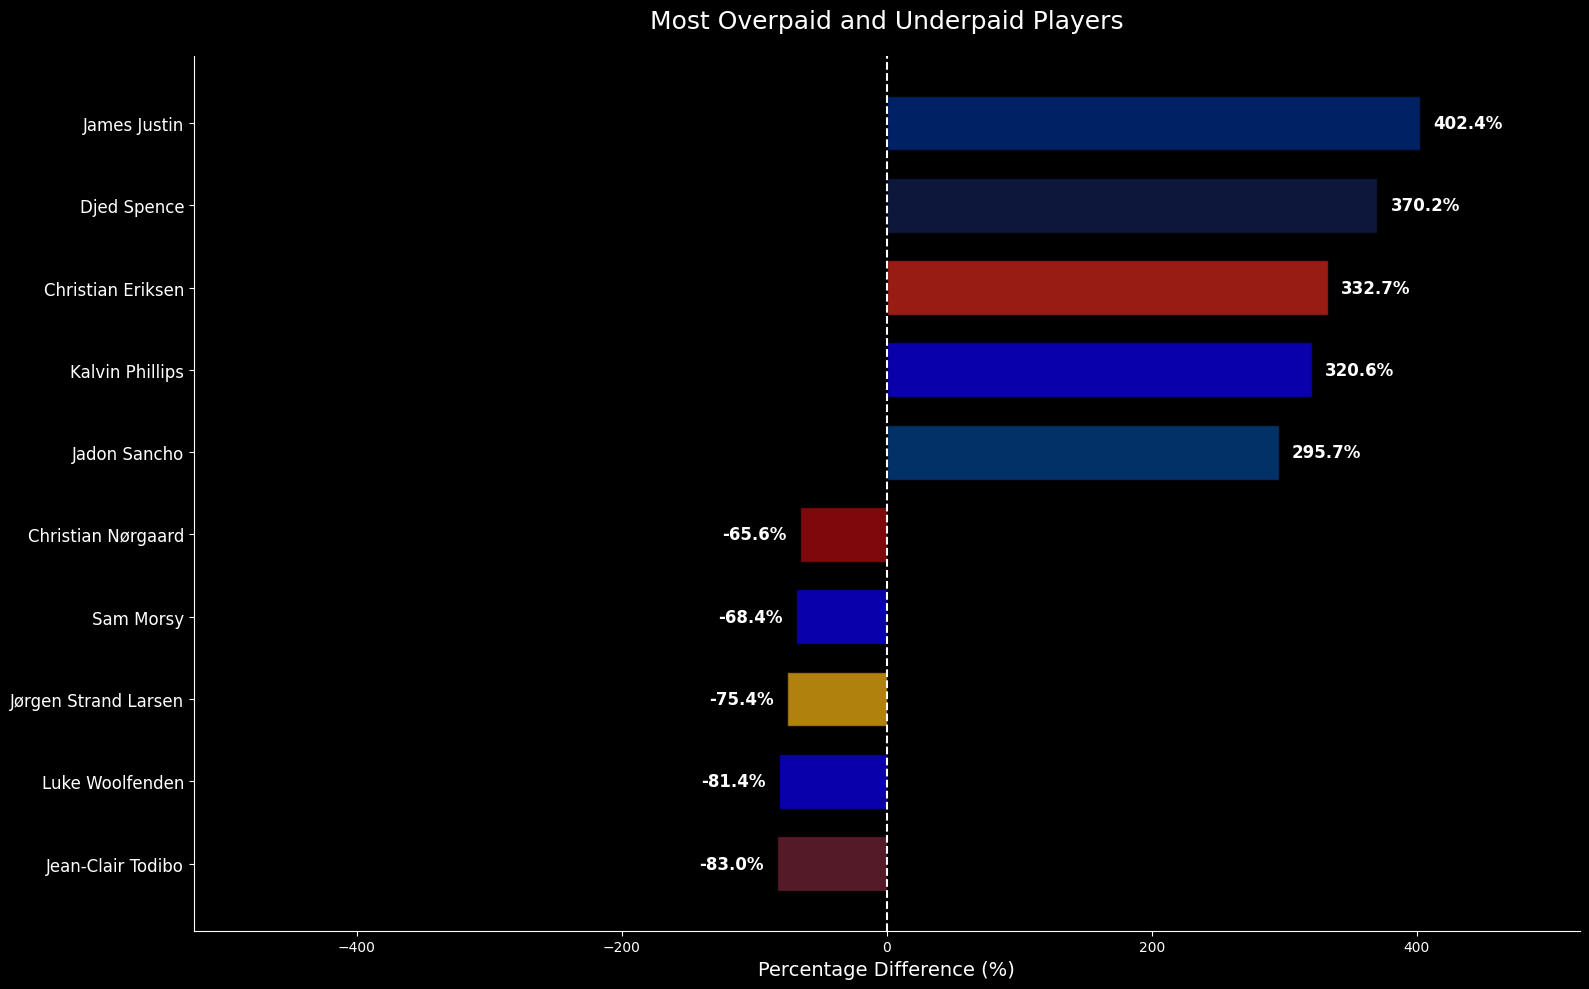

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

def create_centered_bar_chart_with_team_colors(df, top_n=5):

    # Define the team color dictionary
    colour_dict = {
        "Arsenal": "#EF0107",
        "Aston Villa": "#670e36",
        "Bournemouth": "#DA291C",
        "Brentford": "#B50E12",
        "Brighton": "#0057B8",
        "Chelsea": "#034694",
        "Crystal Palace": "#1B458F",
        "Everton": "#003399",
        "Nott'm Forest": "#DD0000",
        "Fulham": "#ffffff",
        "Ipswich": "#0e00f7",
        "Leicester": "#003090",
        "Liverpool": "#c8102E",
        "Man City": "#6CABDD",
        "Man UFC": "#DA291C",
        "Newcastle": "#241F20",
        "Southampton": "#d71920",
        "Tottenham": "#132257",
        "West Ham": "#7A263A",
        "Wolves": "#FDB913",
    }

    # Extract top overpaid and underpaid players
    overpaid = df.nlargest(top_n, 'Percentage_Difference')
    underpaid = df.nsmallest(top_n, 'Percentage_Difference')

    # Combine and sort data for plotting
    chart_data = pd.concat([overpaid, underpaid]).sort_values(
        by='Percentage_Difference', ascending=False
    )
    chart_data['Name'] = chart_data['Name']

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(16, 10))

    # Adjust bar positions and heights
    ypos = range(len(chart_data))
    bar_height = 2  # Adjusted bar thickness
    gap = 3         # Adjusted gap between bars

    # Plot horizontal bars
    for i, row in enumerate(chart_data.itertuples()):
        xpos = row.Percentage_Difference

        # Get team color from the dictionary
        team_color = colour_dict.get(row.Club, "gray")  # Default to gray if team is not in the dict

        # Horizontal bar
        ax.barh(
            i * gap,
            xpos,
            color=team_color,
            alpha=0.7,
            height=bar_height,
            edgecolor="black",
        )

        # Add percentage labels further to the right and in white
        label_position = xpos + (10 if xpos > 0 else -10)
        alignment = "left" if xpos > 0 else "right"
        ax.text(
            label_position,
            i * gap,
            f"{xpos:.1f}%",
            va="center",
            ha=alignment,
            fontsize=12,
            color="white",
            weight="bold",
        )

    # Set y-axis labels (player names only) and reverse order
    ax.set_yticks([i * gap for i in range(len(chart_data))])
    ax.set_yticklabels(chart_data['Name'], fontsize=12)
    ax.invert_yaxis()  # Flip to have the most overpaid at the top

    # Add a vertical line at 0
    ax.axvline(0, color="white", linewidth=1.5, linestyle="--")

    # Customize spines and title
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Most Overpaid and Underpaid Players", fontsize=18, loc="center", pad=20)
    ax.set_xlabel("Percentage Difference (%)", fontsize=14)
    ax.set_xlim([-max(abs(chart_data['Percentage_Difference'])) * 1.3, 
                 max(abs(chart_data['Percentage_Difference'])) * 1.3])

    # Final adjustments
    plt.tight_layout()
    plt.show()

# Call the function with your data
create_centered_bar_chart_with_team_colors(premier_league_analysis)


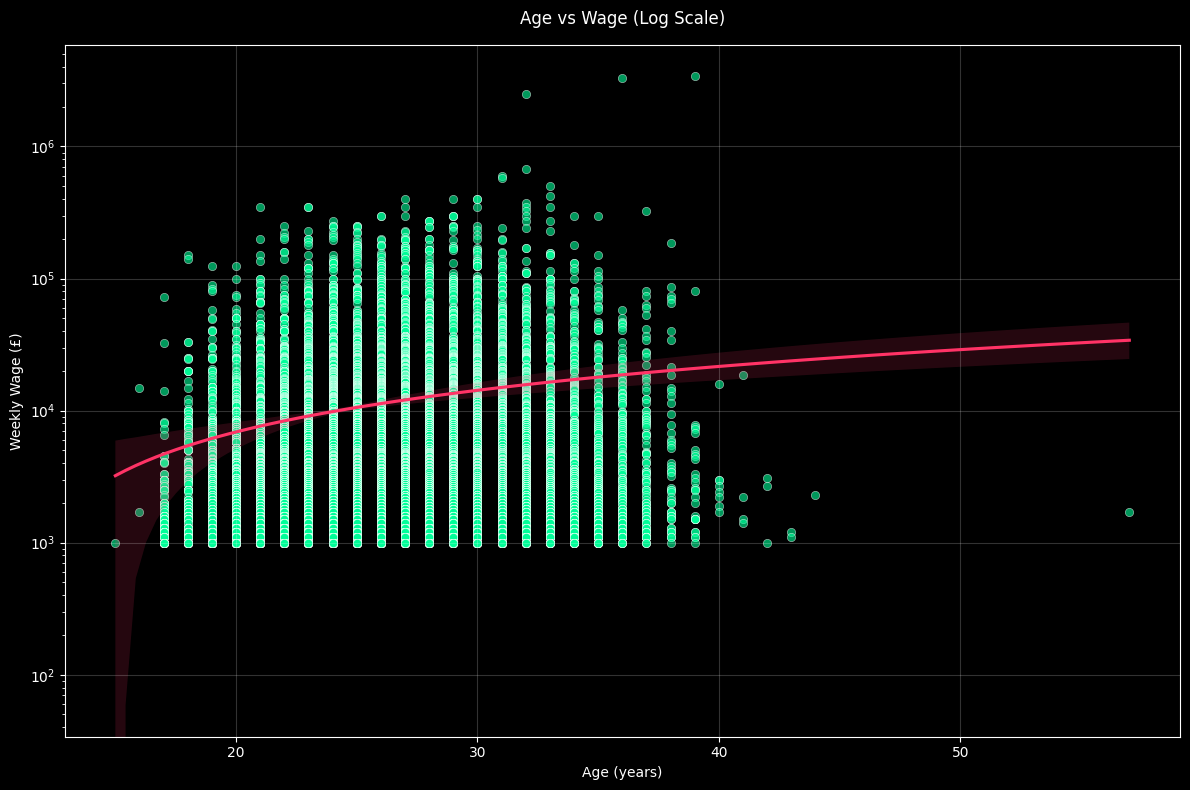

In [12]:
# Set style to dark theme
plt.style.use('dark_background')

# Create figure and plot
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line
sns.scatterplot(data=df, x='Age', y='Wage', alpha=0.6, color='#00ff99')
sns.regplot(data=df, x='Age', y='Wage', scatter=False, color='#ff3366')

# Set log scale and labels
plt.yscale('log')
plt.title('Age vs Wage (Log Scale)', pad=15)
plt.xlabel('Age (years)')
plt.ylabel('Weekly Wage (£)')

# Add subtle grid
plt.grid(True, alpha=0.2)

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
def find_accurate_predictions(df, X, best_model, threshold=0.001):
    """
    Returns players with prediction residuals less than threshold (0.1% by default).
    """
    pred_log = best_model.predict(X)
    predicted_wages = np.expm1(pred_log)
    residuals = np.abs(predicted_wages - df['Wage']) / df['Wage']
    
    mask = residuals < threshold
    results = pd.DataFrame({
        'Name': df.loc[mask, 'Name'],
        'Predicted_Wage': predicted_wages[mask],
        'Actual_Wage': df.loc[mask, 'Wage'],
        'Residual': residuals[mask],
        'Residual_Percentage': residuals[mask] * 100
    })
    
    print("\nMost Accurate Predictions:")
    print("=" * 60)
    
    for _, row in results.iterrows():
        print(f"\nPrediction Results for {row['Name']}:")
        print("-" * 50)
        print(f"Predicted Wage: £{row['Predicted_Wage']:,.2f} per week")
        print(f"Actual Wage: £{row['Actual_Wage']:,.2f} per week")
        print(f"Prediction Error: £{abs(row['Predicted_Wage'] - row['Actual_Wage']):,.2f}")
        print(f"Percentage Error: {row['Residual_Percentage']:.1f}%")
    
    return results

def find_largest_residuals(df, X, best_model, n=5):
    """
    Returns top n players with largest absolute wage prediction residuals.
    """
    pred_log = best_model.predict(X)
    predicted_wages = np.expm1(pred_log)
    residuals = np.abs(predicted_wages - df['Wage'])
    residuals_pct = residuals / df['Wage'] * 100
    
    results = pd.DataFrame({
        'Name': df['Name'],
        'Predicted_Wage': predicted_wages,
        'Actual_Wage': df['Wage'],
        'Absolute_Residual': residuals,
        'Residual_Percentage': residuals_pct
    })
    
    largest_errors = results.nlargest(n, 'Absolute_Residual')
    
    print("\nLargest Prediction Errors:")
    print("=" * 60)
    
    for _, row in largest_errors.iterrows():
        print(f"\nPrediction Results for {row['Name']}:")
        print("-" * 50)
        print(f"Predicted Wage: £{row['Predicted_Wage']:,.2f} per week")
        print(f"Actual Wage: £{row['Actual_Wage']:,.2f} per week")
        print(f"Prediction Error: £{row['Absolute_Residual']:,.2f}")
        print(f"Percentage Error: {row['Residual_Percentage']:.1f}%")
    
    return largest_errors

accurate_predictions = find_accurate_predictions(df, X, best_model)



Most Accurate Predictions:

Prediction Results for Loïs Openda:
--------------------------------------------------
Predicted Wage: £89,956.54 per week
Actual Wage: £90,000.00 per week
Prediction Error: £43.46
Percentage Error: 0.0%

Prediction Results for Alexandr Golovin:
--------------------------------------------------
Predicted Wage: £76,070.25 per week
Actual Wage: £76,000.00 per week
Prediction Error: £70.25
Percentage Error: 0.1%

Prediction Results for Chris Richards:
--------------------------------------------------
Predicted Wage: £49,987.33 per week
Actual Wage: £50,000.00 per week
Prediction Error: £12.67
Percentage Error: 0.0%

Prediction Results for Arnór Sigurðsson:
--------------------------------------------------
Predicted Wage: £14,989.06 per week
Actual Wage: £15,000.00 per week
Prediction Error: £10.94
Percentage Error: 0.1%

Prediction Results for Sandi Lovrić:
--------------------------------------------------
Predicted Wage: £14,747.93 per week
Actual Wage: £

In [22]:
def find_largest_residuals(df, X, best_model, n=5):
    """
    Returns top n players with largest absolute wage prediction residuals with formatted output.
    """
    pred_log = best_model.predict(X)
    predicted_wages = np.expm1(pred_log)
    actual_wages = df['Wage'].values
    residuals = np.abs(predicted_wages - actual_wages)
    
    results = pd.DataFrame({
        'Name': df['Name'],
        'Predicted_Wage': predicted_wages,
        'Actual_Wage': actual_wages,
        'Absolute_Residual': residuals
    })
    
    largest_errors = results.nlargest(n, 'Absolute_Residual')
    
    for _, row in largest_errors.iterrows():
        print(f"\nPrediction Results for {row['Name']}:")
        print("-" * 50)
        print(f"Predicted Wage: £{row['Predicted_Wage']:,.2f} per week")
        print(f"Actual Wage: £{row['Actual_Wage']:,.2f} per week")
        print(f"Prediction Error: £{row['Absolute_Residual']:,.2f}")
        print(f"Percentage Error: {(row['Absolute_Residual'] / row['Actual_Wage'] * 100):.1f}%")
    
    return largest_errors

largest_errors = find_largest_residuals(df, X, best_model)



Prediction Results for Cristiano Ronaldo:
--------------------------------------------------
Predicted Wage: £851,507.81 per week
Actual Wage: £3,400,000.00 per week
Prediction Error: £2,548,492.19
Percentage Error: 75.0%

Prediction Results for Karim Benzema:
--------------------------------------------------
Predicted Wage: £949,818.81 per week
Actual Wage: £3,300,000.00 per week
Prediction Error: £2,350,181.19
Percentage Error: 71.2%

Prediction Results for Neymar:
--------------------------------------------------
Predicted Wage: £1,598,276.75 per week
Actual Wage: £2,500,000.00 per week
Prediction Error: £901,723.25
Percentage Error: 36.1%

Prediction Results for Marco Verratti:
--------------------------------------------------
Predicted Wage: £99,250.01 per week
Actual Wage: £575,000.00 per week
Prediction Error: £475,749.99
Percentage Error: 82.7%

Prediction Results for Sadio Mané:
--------------------------------------------------
Predicted Wage: £307,355.66 per week
Actual 